## Objective
Create spatial waveform plots and ms-scale raster plots to demonstrate Kilosort2 undermerging units.

In [1]:
# region Set up notebook imports
%load_ext autoreload
%autoreload 2
# Allow for imports of other scripts
import sys
PATH = "/data/MEAprojects/PropSignal"
if PATH not in sys.path:
    sys.path.append(PATH)
# Reload a module after changes have been made
from importlib import reload
# endregion

import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import sys
from pathlib import Path
from tqdm import tqdm

from src import utils
from src.recording import Recording
from src.sorters.prop_signal import PropSignal
from src.sorters.kilosort import Kilosort
from src.comparison import Comparison

## Setup recording and sorters

In [3]:
recording = Recording(utils.PATH_REC_SI, freq_min=300, freq_max=6000)
rms = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_5_full/5rms.npy")
##
rec_duration_ms = int(recording.get_total_duration() * 1000)

/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kwargs["name"]))


In [16]:
"""
If i is the index of a channel, then the ith element of self.nearest_chan is a tuple
    0) Closest channels indices: An where the 0th element is i, 1st element is closest channel, 2nd element is second closest channel, etc.
    1) Distance of channels
"""
nearest_chan = []
locs = recording.get_channel_locations()
# locs[:, 0] *= 1.5
for i in range(len(locs)):
    loc = locs[i]
    dists = np.sqrt(np.sum(np.square(locs - loc), axis=1))
    dists_sorted = np.sort(dists)
    chans_sorted = np.argsort(dists)

    nearest_chan.append((chans_sorted, dists_sorted))

In [4]:
prop_signal = PropSignal("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230531", recording)

In [13]:
kilosort = Kilosort(utils.PATH_SM4_SI, "first", recording)
kilosort_spike_times = kilosort.get_spike_times()

Getting spike times
Getting match counts and agreement scores


100%|██████████| 84/84 [00:21<00:00,  3.97it/s]

Num Prop.: 84
Num Kilosort2: 339
Num single matches: 65

For Prop.:
Num max matches: 67
Num unique max matches: 47

For Kilosort2:
Num max matches: 142
Num unique max matches: 48


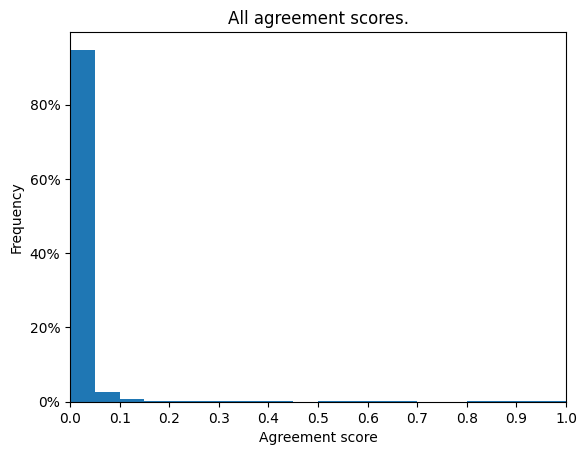

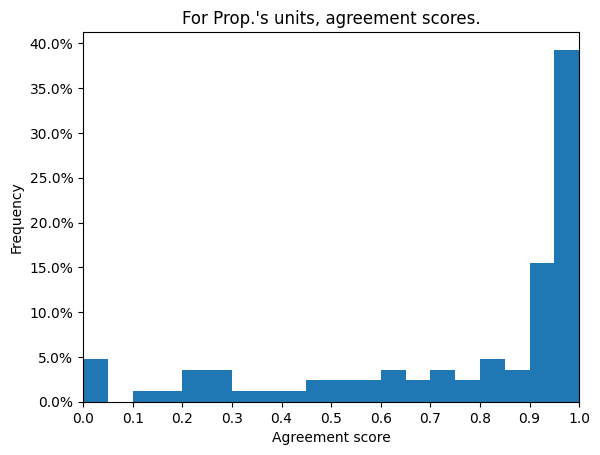

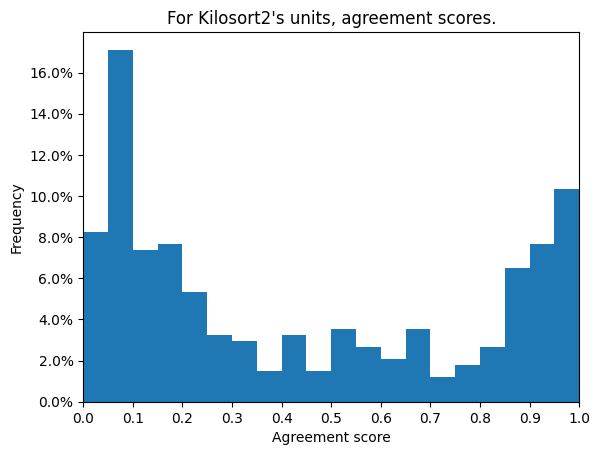

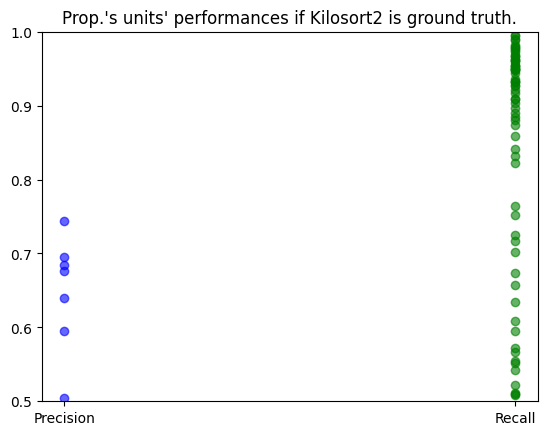

In [7]:
comparison = Comparison(prop_signal, kilosort, score_formula=2)

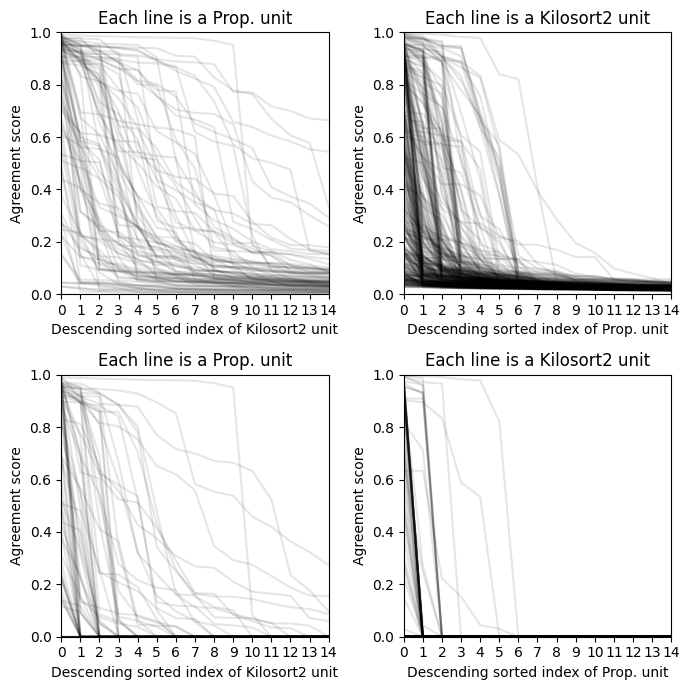

In [11]:
comparison.plot_line_comps()

## Setup functions and classes

In [8]:
ROOT_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230531/max_ks_to_prop")

In [9]:
def get_path_kilosort(ks_idx):
    """
    Get path to data as formatted by templates_spatial.ipynb
    """
    score = np.max(comparison.agreement_scores[:, ks_idx])
    return ROOT_PATH / f"{score*100:.0f}_{ks_idx}"


def get_template_kilosort(ks_idx):
    """
    Get data extracted with templates_spatial.ipynb
    ROOT_PATH/{score}_{ks_idx}/
        (waveforms)
        unmatched_prop.npy
        unmatched_ks.npy
        matched.npy
    """

    path = get_path_kilosort(ks_idx)

    waveforms_ks = np.load(path / "unmatched_ks.npy", mmap_mode="r")
    waveforms_matched = np.load(path / "matched.npy", mmap_mode="r")

    if waveforms_matched.size == 0:
        waveforms = waveforms_ks
    elif waveforms_ks.size == 0:
        waveforms = waveforms_matched
    else:
        waveforms = np.concatenate([waveforms_ks, waveforms_matched], axis=0)

    return np.mean(waveforms, axis=0)

In [10]:
def bound_spike_times(st, start_ms, end_ms):
    st = np.array(st)
    return st[(start_ms <= st) & (st <= end_ms)]

In [24]:
class UnderMerge:
    """
    Class to represent one or more kilosort units that match to the same prop unit
    """
    CMAP_KS_UNITS = plt.get_cmap("tab10")

    def __init__(self, prop_idx, match_thresh=0.5):
        ks_scores = comparison.agreement_scores[prop_idx, :]
        ks_ind = np.flatnonzero(ks_scores >= match_thresh)
        if ks_ind.size == 0:
            ks_ind = np.argsort(ks_scores)[-3:]

        ks_scores = ks_scores[ks_ind]

        # Order kilosort units by descending average amplitude
        amps = [np.min(get_template_kilosort(idx)) for idx in ks_ind]
        order = np.argsort(amps)

        self.ks_ind = ks_ind[order]
        self.ks_scores = ks_scores[order]
        self.ks_colors = [self.CMAP_KS_UNITS(i) for i in range(len(self))]
        self.prop = prop_signal[prop_idx]

    def plot_template(self, save=False):
        XLIM = (2, 68)

        WINDOW_HALF_SIZE = 90  # length and width of window will be WINDOW_HALF_SIZE * 2
        SCALE_H = 0.03 # Multiple height of waveform by this to scale it down

        MAX_LATENCY = 15  # In frames
        CMAP_LATENCY = plt.get_cmap("viridis", MAX_LATENCY)  # tab20c

        MAX_DOT_SIZE = 55  # For marking which channels are in prop unit
        MARKERS = "oXDs*pP1267" # For distinguishing between props in a merge

        # Find which channels to plot
        chan_center = self.prop.chan
        loc_center = locs[chan_center]

        chans, dists = nearest_chan[chan_center]
        max_dist = np.sqrt(2) * WINDOW_HALF_SIZE  # Distance from center of window to corner

        scale = lambda y: y * SCALE_H + loc[1]

        # 1 axis with all units + 1 axis for each unit
        num_axes = 1 + len(self.ks_ind)
        figsize = (4.5*num_axes, 9)
        fig, axes = plt.subplots(1, num_axes, figsize=figsize, tight_layout=False)

        # Setup axes
        ymin = max(0, loc_center[1]-WINDOW_HALF_SIZE)
        ymax = ymin + WINDOW_HALF_SIZE*2
        for axis in axes:
            # fig.suptitle("Title")
            axis.set_aspect("equal")
            axis.set_xlabel("x (μm)")
            axis.set_ylabel("y (μm)")

            axis.set_xlim(*XLIM)
            axis.set_ylim(ymin, ymax)

            ## Mark which electrodes are in the prop signal
            # Determine which prop has largest latencies
            # colorbar_i = np.argmax([np.max(prop.latency) for prop in self.prop.df])

            for i, prop in enumerate(self.prop.df):
                locs_prop = locs[prop.ID] - 4
                locs_prop[:, 1] -= 5*i
                sizes = prop.small_window_cooccurrences.values
                sizes *= MAX_DOT_SIZE/np.max(sizes)
                scatter = axis.scatter(locs_prop[:, 0], locs_prop[:, 1], c=prop.latency.values, s=sizes,
                                    zorder=10, marker=MARKERS[i], cmap=CMAP_LATENCY, vmin=0, vmax=0.5)
                # if colorbar_i == i:
                #     scatter = scat

                # Mark which dot is the first electrode
                axis.scatter(*locs_prop[0, :], color="black", s=sizes[0], zorder=12, marker=MARKERS[i])

        fig.subplots_adjust(right=0.9)
        colorbar_ax = fig.add_axes([0.92, 0.1, 0.04, 0.79])
        colorbar = fig.colorbar(scatter, cax=colorbar_ax, label="Latency (ms)")
        colorbar.set_ticks(np.arange(MAX_LATENCY+1)/recording.get_sampling_frequency())

        for i in range(num_axes-1):
            for axis in (axes[0], axes[1+i]):
                # Plot channel templates for each kilosort unit
                templates = get_template_kilosort(self.ks_ind[i])

                for c in chans:
                    loc = locs[c]

                    # Check if channel is out of bounds
                    if np.sqrt(np.sum(np.square(loc - loc_center))) >= max_dist:
                        break

                    # Plot template
                    temp = templates[c, :]
                    x_values = np.linspace(loc[0]-7, loc[0]+7, temp.size)
                    # axis.plot(x_values, y_values, c="red" if c == chan_center else "black")
                    axis.plot(x_values, scale(temp), c=self.ks_colors[i],
                              alpha=0.5+i*0.00 if axis == axes[0] else 1,
                              label=i if c == chans[0] else None)

                    # Plot 5RMS
                    axis.plot(x_values, [scale(-RMS[c])] * len(x_values), c="red", alpha=0.2, zorder=5)

            axes[1+i].set_title(f"Kilosort ID: {self.ks_ind[i]}")
            score = self.ks_scores[i]
            num_spikes = len(kilosort_spike_times[self.ks_ind[i]])
            axes[1+i].text(np.mean(XLIM), ymin-13,
                      f"Overlap Score: {score:.3f}\n"
                      f"Num overlap: {int(score*num_spikes)}\n"
                      f"Num spikes: {num_spikes}",
                      horizontalalignment='center',verticalalignment='top',
                      fontweight="normal")

        axes[0].set_title(f"Prop ID: {self.prop.id}")
        axes[0].text(np.mean(XLIM), ymin-13,
                  f"Num spikes: {len(self.prop)}",
                  horizontalalignment='center',verticalalignment='top',
                  fontweight="normal")

        if not save:
            plt.show()
        else:
            plt.savefig(ROOT_PATH / f"undermerge/ks/{self.prop.id}.png")
            plt.close(fig)

    def plot_raster_search(self, start_ms, end_ms,
                           window_duration=10, min_count=6,
                           search_ind=None):
        """
        Search for best rasters to plot and plot them

        :param search_ind:
            When searching for which windows to plot
            If None, search all kilosort units
            Else, search only search_ind units
        """

        kses = [bound_spike_times(kilosort_spike_times[ks_idx], start_ms, end_ms)
                for ks_idx in self.ks_ind]
        kses_cat = np.sort(np.concatenate(kses))

        if search_ind is None:
            kses_search = kses_cat
        else:
            kses_search = [bound_spike_times(kilosort_spike_times[ks_idx], start_ms, end_ms)
                          for ks_idx in self.ks_ind[search_ind]]
            kses_search = np.sort(np.concatenate(kses_search))

        idx = 0
        while idx < len(kses_search):
            start = kses_search[idx] - window_duration * 0.2
            left = np.searchsorted(kses_cat, start)
            right = np.searchsorted(kses_cat, start+window_duration, side="right")
            if right - left >= min_count:
                self.plot_raster(start, start+window_duration)
                assert search_ind is None, "idx=right not work for search_ind is None"
                idx = right
            else:
                idx += 1

        # kses = []
        # inds = []
        # for ks_idx in self.ks_ind[search_ind]:
        #     st = bound_spike_times(kilosort_spike_times[ks_idx], start_ms, end_ms)
        #     kses.append(st)
        #     inds.extend([ks_idx] * len(st))
        # kses_cat = np.concatenate(kses)
        # inds = np.asarray(inds)
        #
        # ind_sorted = np.argsort(kses_cat)
        # kses_cat = kses_cat[ind_sorted]
        # inds = inds[ind_sorted]
        #
        # idx = 0
        # while idx < len(kses):
        #     start = kses[idx] - window_duration * 0.2
        #     left = np.searchsorted(kses, start)
        #     right = np.searchsorted(kses, start+window_duration, side="right")
        #     if right - left >= min_count:
        #         self.plot_raster(start, start+window_duration)
        #     idx += 1


    def plot_raster(self, start_ms, end_ms):
        LINE_SIZE = 450

        fig, ax = plt.subplots(1, figsize=(6.5, 1.5), tight_layout=True)

        # Prop signal units' spike times
        prop = bound_spike_times(self.prop.spike_train, start_ms, end_ms)
        for st in prop:
            ax.scatter(st, 1, color="black", marker="|", s=LINE_SIZE, alpha=1)

        # Kilosort units' spike times
        kses = [bound_spike_times(kilosort_spike_times[ks_idx], start_ms, end_ms) for ks_idx in self.ks_ind]
        kses_cat = np.concatenate(kses)

        ks_unique, count = np.unique(kses_cat, return_counts=True)
        ks_overlap = set(ks_unique[count>1])  # Find if multiple ks units spike at same time

        for i in range(len(kses)):
            for st in kses[i]:
                y = -1
                if st in ks_overlap: y -= i*0.05
                ax.scatter(st, y, color=self.CMAP_KS_UNITS(i), marker="|", s=LINE_SIZE, alpha=1)

        ax.set_xlim(start_ms-0.01, end_ms+0.01)
        ax.set_xlabel("Time (ms)")
        ax.set_ylim(-2, 2)
        ax.set_yticks([])
        # ax.set_title(title)
        plt.show()

    def __len__(self):
        return len(self.ks_ind)

##

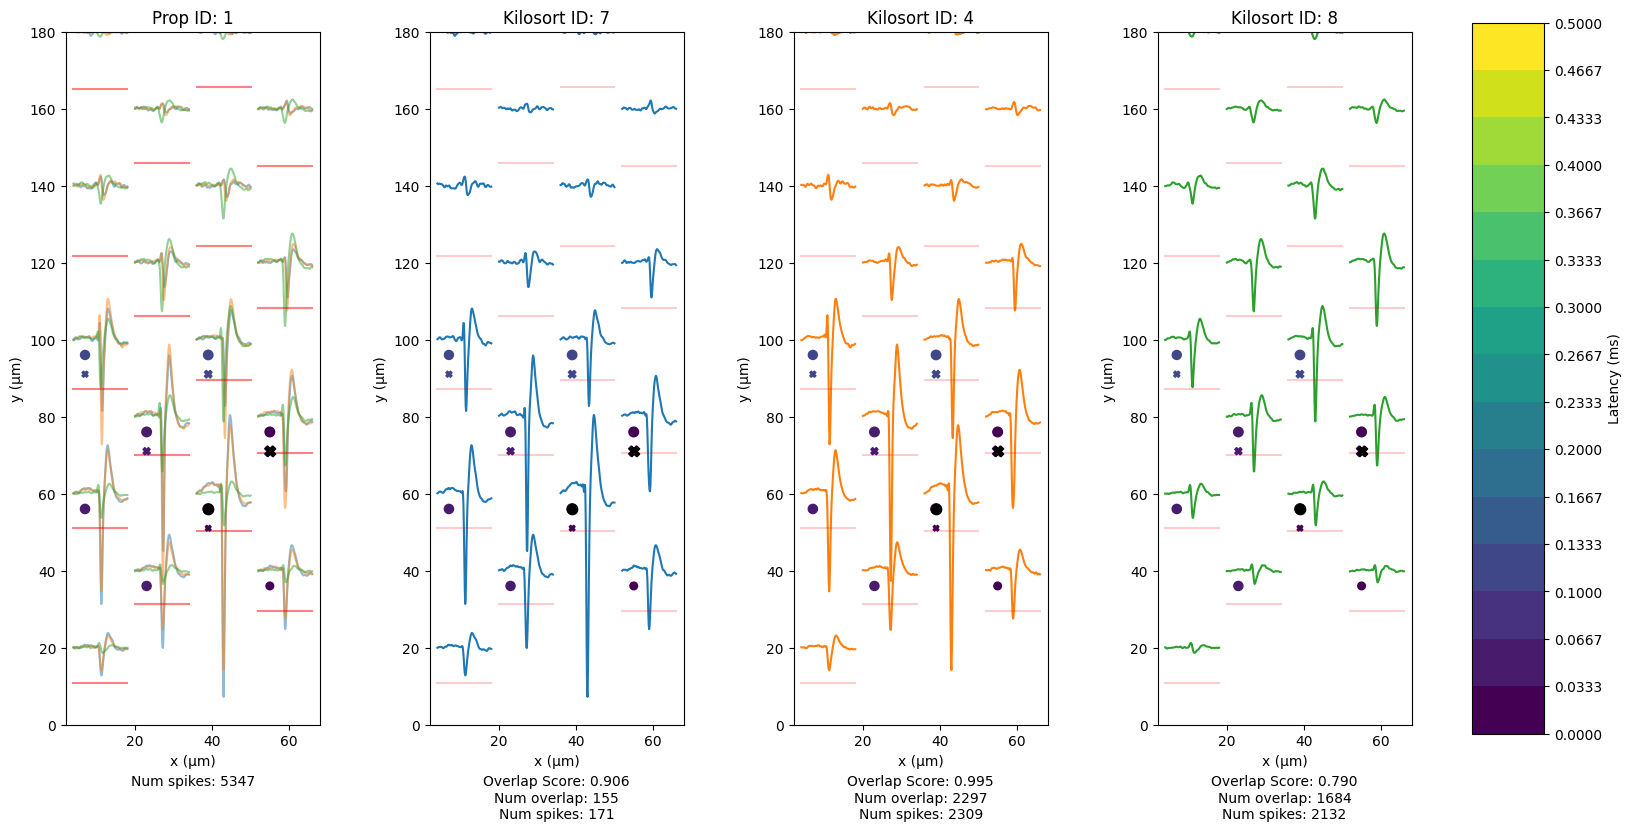

In [21]:
prop_idx = 1
under_merge = UnderMerge(prop_idx, match_thresh=0.5) # 0.3
under_merge.plot_template()
# under_merge.plot_raster_search(0, rec_duration_ms, window_duration=200, min_count=6, search_ind=None)

In [25]:
# Create the plots
def job_plot(prop_idx):
    UnderMerge(prop_idx).plot_template(save=True)

with Pool(processes=22) as pool:
    tasks = range(len(prop_signal))
    for _ in tqdm(pool.imap(job_plot, tasks), total=len(tasks)):
        pass

100%|██████████| 84/84 [00:19<00:00,  4.33it/s]


In [ ]:
# MATCH_THRESH = 0.5
# ##
# under_merges_all = []
# # for prop_idx in range(len(prop_signal)):
# prop_idx = 35
# ks_scores = comparison.agreement_scores[prop_idx, :]
# ks_ind = np.flatnonzero(ks_scores >= MATCH_THRESH)
# ks_scores = ks_scores[ks_ind]
# under_merge = UnderMerge(ks_ind, ks_scores, prop_signal[prop_idx])
# under_merge.plot()